<a href="https://colab.research.google.com/github/9characters/ML-projects/blob/main/Using_TPU_for_Efficient_Distributed_Learining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9: Distributed Learning using CelebA Image dataset along with TPU
### Making use of TPU Strategy to implement clusters for distributed learning using TPU

### Learning Objectives
* Understand how Distributed learning works (using CNN)
* Learn the difference- between Distributed Learning and Federated Learning.
* Learn to use TPUStrategy for distributed learning.


### Imports
Import all the necessary libraries for the lab such as tensorflow, numpy, pandas, and keras.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from imutils import paths
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout

### Mount Google Drive

In the code cell below, we mount the google drive to the colab environment so that we have access to the local version of the dataset.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read CSV
Use Pandas to load CelebA Image dataset from the CSV file.

In [ ]:
#read the csv file to access the feature "Smiling"
mydata = pd.read_csv('/content/drive/My Drive/Intro2MLDatasets/Lab9/list_attr_celeba.csv')

### Drop features
Drop the features from the dataset which are not needed. Smiling is the label to be predicted and the Image ID  is used as an identifier. All the other features are excluded from the dataset because in this lab we are reading each pixel of an image to be used as a feature and the Smiling attribute as a label. The prediction depends on the model which learns from the pixels of an image. 

In [ ]:
#drop all the other features from the csv except for the image_id and smiling
mydata.drop(mydata.columns.difference(['image_id','Smiling']), 1, inplace=True)
mydata.head(100)

,image_id,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,-1
3,000004.jpg,-1
4,000005.jpg,-1
...,...,...
95,000096.jpg,-1
96,000097.jpg,-1
97,000098.jpg,-1
98,000099.jpg,1


### Labels List
Create a list named Label which corresponds to the feature Smiling. This list will be used later to create training and testing data. 

In [ ]:
labels = list()

# Iterate over dataframe to store target labels for attribute "Smiling"
# Store all the attribute values for Smiling in labels 
for (columnName, columnData) in mydata.iteritems():
  if columnName == 'Smiling':
    for i in range(0, 2988):
      labels.append(columnData.values[i])

### Read image to convert into an array
Load function reads the images from the path provided as a list to the function. It reads the image, flattens the pixel value, and scales it to value [0,1] and returns the list of lists where each list is the scaled pixel value of one image.

In [ ]:
#Given a path, iterate over and read each image and convert to an array 
def load(path):
  data = list()

  for imgpath in path:
    im_grayscale= cv2.imread(imgpath, 0)
    image = np.array(im_grayscale)
    # .flatten()
    # image = image.reshape((218, 178, 1))
    #scales the image to [0,1] and adds to the list
    data.append(image/255)

  return data

### Image path
Create path for each image from the folder and call the load function. The length of image_list and labels are equal.

In [ ]:
file = open("/content/drive/MyDrive/image_list.pkl", "rb")

In [ ]:
from pickle import load
image_list = load(file)

In [ ]:
image_list

[array([[0.62745098, 0.62745098, 0.62745098, ..., 0.59607843, 0.58823529,
         0.58823529],
        [0.62745098, 0.62745098, 0.62745098, ..., 0.64313725, 0.61960784,
         0.61960784],
        [0.62745098, 0.62745098, 0.62745098, ..., 0.61960784, 0.64313725,
         0.64313725],
        ...,
        [0.35686275, 0.35294118, 0.34509804, ..., 0.34509804, 0.35294118,
         0.35294118],
        [0.31764706, 0.33333333, 0.34901961, ..., 0.34901961, 0.35686275,
         0.35686275],
        [0.31764706, 0.33333333, 0.34901961, ..., 0.34901961, 0.35686275,
         0.35686275]]),
 array([[0.39215686, 0.40392157, 0.41960784, ..., 0.52156863, 0.52156863,
         0.52156863],
        [0.41568627, 0.40392157, 0.39215686, ..., 0.52156863, 0.52156863,
         0.52156863],
        [0.38431373, 0.38431373, 0.39215686, ..., 0.52156863, 0.52156863,
         0.52156863],
        ...,
        [0.04313725, 0.03921569, 0.03137255, ..., 0.17647059, 0.15686275,
         0.15686275],
        [0.0

In [ ]:
file.close()

In [ ]:
image_path = '/content/drive/My Drive/Intro2MLDatasets/images_celeba'
img_paths = list(paths.list_images(image_path)) 

image_list = load(img_paths)

In [ ]:
from pickle import dump
dump(image_list, open("image_list.pkl", "wb"))

In [ ]:
!cp /content/image_list.pkl /content/drive/MyDrive/image_list.pkl

### Convert labels into binary and split data
Convert the label into binary format and split the data into train and test.

In [ ]:
#convert the label into binary data 0 or 1
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

#Split feature and label into train and test sets
x_train, x_test, y_train, y_test = train_test_split(image_list, labels, test_size=0.1, shuffle=True)

#convert all the variables to numpy array, and float32 type 
x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

### Create Model
Create Neural network model with multiple layers. The functionality for each layers are defined below in the code cell.

https://www.kaggle.com/pavansanagapati/a-simple-cnn-model-beginner-guide

In [ ]:
def create_model(shape, classes):
  model = Sequential()
  """
  (218, 178, 3) is the shape of celebA image datasets.
  # Batch Normalization is used to make neural networks faster and more stable through normalization of layers inputs by recentering and rescaling. It maintains mean output close to 0 and the standard deviation close to 1.
  Conv2D is basically a 2D convolutional layer used for image processing kernel which helps produce a tensor of outputs.
  Maxpooling2D downsamples the input along its spatial dimension(height and width). The window is shifted by strides along each dimension.
  Dropout prevents overfitting. Fraction of input units to drop.
  Dense layer is the network layer in the model which feeds all outputs from the previous layer to all its neurons. Each neuron provides one output to the next layer.
  """

  model.add(Conv2D(64, input_shape=shape, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(200, activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(200, activation="relu"))
  model.add(Dropout(0.25))
  model.add(Dense(classes, activation="sigmoid"))

  return model

### TPU 
Using TPU strategy for synchronous training on TPUs.

In [ ]:
"""
tf.distribute.TPUStrategy lets you run your tf training on Tensor Processing Units (TPU). TPUs dramatically accelerates machine learning workloads.  
TPUStrategy implements synchronous distributed training. TPUs provide their own implementation of efficient all-reduce and other collective operations across multiple TPU cores.
"""
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
  model = create_model((218, 178, 1), 1)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      loss='binary_crossentropy',
      metrics=['accuracy'])

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.17.91.10:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.17.91.10:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [ ]:
  model = create_model((218, 178, 1), 1)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
      loss='binary_crossentropy',
      metrics=['accuracy'])

In [ ]:
# tf.get_logger().setLevel('ERROR')
validation_frequency = 5
history = model.fit(x_train, 
                    y_train, 
                    epochs=15,
                    steps_per_epoch=30,
                    validation_data=(x_test, y_test),
                    validation_freq=validation_frequency)

Epoch 1/15
30/30 [==============================] - 39s 297ms/step - loss: 0.8170 - accuracy: 0.4961
Epoch 2/15
30/30 [==============================] - 9s 284ms/step - loss: 0.6998 - accuracy: 0.5050
Epoch 3/15
30/30 [==============================] - 8s 282ms/step - loss: 0.6934 - accuracy: 0.5017
Epoch 4/15
30/30 [==============================] - 8s 283ms/step - loss: 0.6943 - accuracy: 0.4931
Epoch 5/15
30/30 [==============================] - 9s 307ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6926 - val_accuracy: 0.5585
Epoch 6/15
30/30 [==============================] - 8s 283ms/step - loss: 0.6930 - accuracy: 0.5125
Epoch 7/15
30/30 [==============================] - 8s 283ms/step - loss: 0.6930 - accuracy: 0.5147
Epoch 8/15
30/30 [==============================] - 8s 283ms/step - loss: 0.6928 - accuracy: 0.5165
Epoch 9/15
30/30 [==============================] - 8s 283ms/step - loss: 0.6927 - accuracy: 0.5177
Epoch 10/15
30/30 [==============================] - 9s 2

In [ ]:
def plot_training_history(history, title=None):
    fig = plt.figure(figsize=(9,9))
    plt.plot(history['accuracy'], label='acc')
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_accuracy'], label='val_acc')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy and loss plot')
    plt.legend(loc='best')

break [0.8169990181922913, 0.6998102068901062, 0.693413496017456, 0.6942740678787231, 0.6930258274078369, 0.6929614543914795, 0.6929938197135925, 0.6928460597991943, 0.6927056312561035, 0.6928864121437073, 0.6923791170120239, 0.693078875541687, 0.6924132108688354, 0.6923509240150452, 0.6924939155578613]
[0.8169990181922913, 0.6998102068901062, 0.693413496017456, 0.6942740678787231, 0.6930258274078369, 0.6929614543914795, 0.6929938197135925, 0.6928460597991943, 0.6927056312561035, 0.6928864121437073, 0.6923791170120239, 0.693078875541687, 0.6924132108688354, 0.6923509240150452, 0.6924939155578613]
break2 [0.8169990181922913, 0.6929614543914795, 0.6923791170120239]
break [0.496095210313797, 0.5050204396247864, 0.5016734600067139, 0.49312013387680054, 0.5105987191200256, 0.5124581456184387, 0.5146895051002502, 0.5165489315986633, 0.5176645517349243, 0.5132019519805908, 0.5206396579742432, 0.5150613784790039, 0.5210115313529968, 0.5146895051002502, 0.5184083580970764]
[0.496095210313797, 0

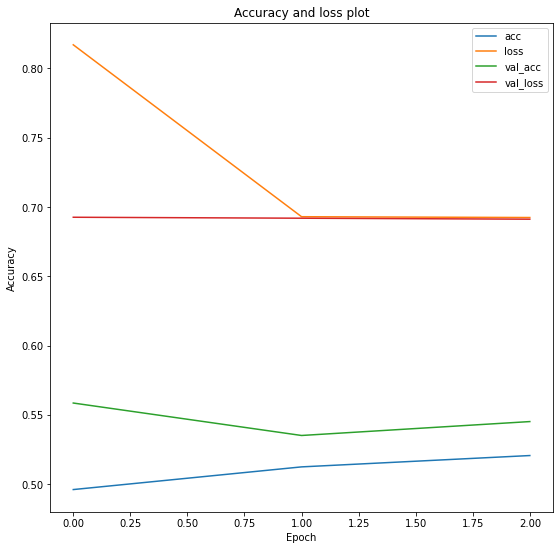

In [ ]:
for metric in ["loss", "accuracy"]:
    metric_series = history.history[metric]
    print('break', history.history[metric])
    print(metric_series)

    temp = []
    for i in range(0, len(metric_series), validation_frequency):
      temp.append(metric_series[i])
    history.history[metric] = temp
    
    print('break2', history.history[metric])

plot_training_history(history.history)

 **Assignment**

**We have ML scenario with 100 devices which could use Federated Learning (FL) or Distributed Learning (DL). Let's assume that each device generates 25GB of data every hour. Let's consider that the DL and FL training process takes more or less same time (say approx. 20 minutes). For this scenario, answer the following questions:**
  
1. **In Distributed Learning, how long would it take to exchange this data using 100 Mbps communication link if we are updating the learning model every hour? Approximately how long would it take to get the learning model ready for inferencing or prediction for each device?**

2. **In Federated Learning, how long would it take to exchange 100 parameters(each parameter is 1KBytes) from each client to FL server using 100 Mbps communication link if we are updating the learning model every hour and sending the global model back to the client? Let's assume that FL server takes about 2 mins for generating global model. Approximately how long would it take to get the learning model ready for inferencing or prediction for each device?**

3. **Based on 1 and 2, provide your observations on DL and FL.**